# Day 12: Intro to Probability

---

- motivation: variable material properties
- probability density function
- cumulative distribution function
- quantile function

### Important Caveat: This class does **not** satisfy the prob/stat requirement...

Before we start, let me give you a warning:

> I'm going to teach you useful content in this class. However, I'm going to gloss over the whole subject of statistics. So long as you're dealing not dealing with safety-critical systems, you can get far with what I'm going to teach. If you're working on safety-critical systems someday, make sure to take a class on statistics, or better yet on reliability engineering.


In [10]:
import pandas as pd 
import grama as gr 
import numpy as np
from scipy.optimize import minimize
from plotnine import *
DF = gr.Intention()

## Dataset of steel alloy specimens
from grama.data import df_ruff


## Motivating Example:

When doing mechanical design, we need "material properties":

| Property | Symbol |
|---|---|
| Density | $\rho$ |
| Elasticity | $E$ |
| Strength (yield) | $\sigma_y$ |
| Strength (ultimate) | $\sigma_u$ |

We can often find "material properties" via Google search; for instance, you can find the following page by searching for "aluminum 6061 strength":

[MatWeb aluminum page](http://www.matweb.com/search/datasheet_print.aspx?matguid=1b8c06d0ca7c456694c7777d9e10be5b)

But why does this page have the scary warning:

> Data points with the AA note have been provided by the Aluminum Association, Inc. and are NOT FOR DESIGN.

*Probability* is **key** to understanding why!


### Look at some materials data

Tensile testing gives us information on the *strength* of materials:

![tensile specimens](./images/Tensile_specimen-round_and_flat.jpg)

Via Wikimedia Commons.

Every individual specimen gives us a *different* material property value, for instance the following is a set of tests on cast steel tensile yield strength (TYS, ksi) and tensile ultimate strength (TUS, ksi), along with part thicknesses (in) and part identifiers.


In [2]:
df_ruff


,part,TYS,TUS,thickness
0,aa,157.0,164.7,0.485
1,ab,159.6,168.2,0.625
2,ac,155.6,165.4,0.625
3,ha,165.8,174.0,0.375
4,hb,157.4,163.8,1.000
5,hc,158.4,164.6,0.500
6,hd,157.6,167.3,0.150
7,ba,156.4,161.7,3.000
8,bb,157.7,162.7,3.000
9,ga,155.7,164.4,0.500


### Q: What do you observe based on the following plot?


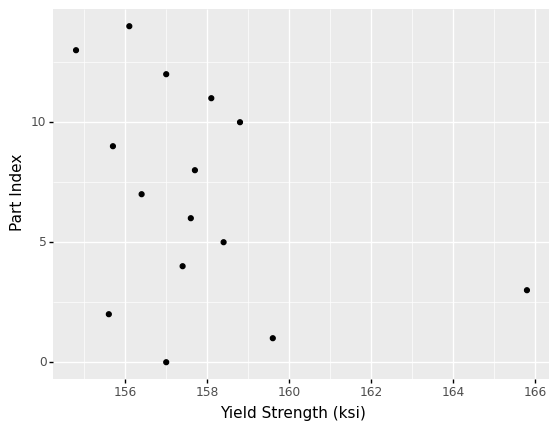

<ggplot: (8734595368542)>

In [3]:
(
    df_ruff
    >> gr.tf_mutate(idx=DF.index)
    
    >> ggplot(aes(y="idx", x="TYS"))
    + geom_point()
    + labs(
        y="Part Index",
        x="Yield Strength (ksi)"
    )
)

Let's imagine "stacking" all of the dots:

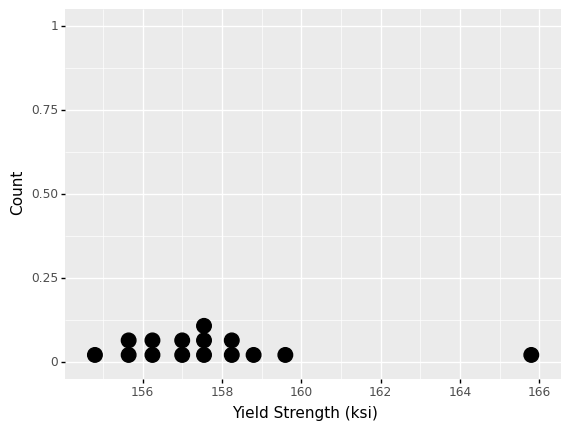

<ggplot: (8734646773661)>

In [4]:
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_dotplot(bins=30)
    
    + labs(
        y="Count",
        x="Yield Strength (ksi)"
    )
)


We could instead count the dots in bins; this is a histogram:


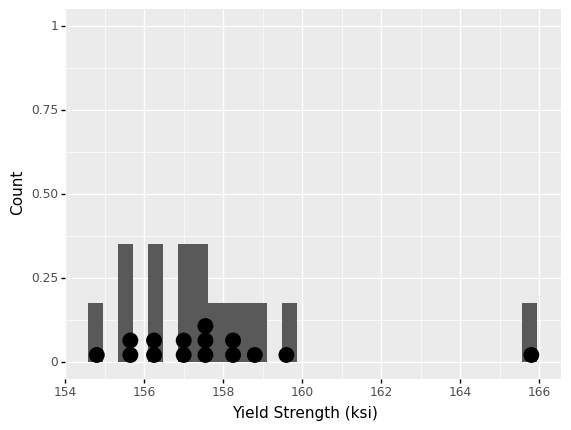

<ggplot: (8734590523691)>

In [5]:
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_histogram(aes(y="stat(density)"), bins=30)
    + geom_dotplot(bins=30)
    
    + labs(
        y="Count",
        x="Yield Strength (ksi)"
    )
)


### Using materials data for design

Imagine we want to design parts that will fail at a rate of 1 in 2. 

### Q: What *single value* of Yield Strength (`TYS`) should we use to get failures at a rate of 1 in 2, based on the data below?


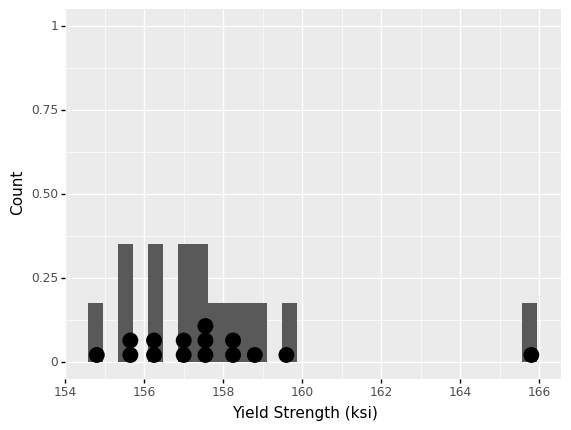

<ggplot: (8734590489588)>

In [6]:
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_histogram(aes(y="stat(density)"), bins=30)
    + geom_dotplot(bins=30)
    
    + labs(
        y="Count",
        x="Yield Strength (ksi)"
    )
)


### Q: What if we want failure at a rate of 1 in 100? What value of Yield Strength (`TYS`) would you use?

<!-- (Are the data *sufficient* to make this choice?) -->

# Random Variables

---

What is a random variable? I'm going to give you two viewpoints:

> 1. (Theoretical) A random variable __has__ a *function* that describes *relative frequencies*.
> 
> 2. (Practical) A random variable __is__ a variable that has *no single, well-defined value*.

[Theoretically](https://en.wikipedia.org/wiki/Probability_density_function#Example), a random variable is defined by a function that precisely defines how frequently particular values tend to occur. Practically, we will use random variables to model *uncertain* quantities.


The Grama function `gr.marg_named(data, dist)` fits a random variable based on two pieces of information:

- `data` is a dataset used to inform the model
- `dist` is a string used to select a particular distribution

It is common to model strength using a lognormal (`"lognorm"`) distribution; let's do that:


In [7]:
## Fit a marginal
marg_tys = gr.marg_named(df_ruff.TYS, "lognorm")

### Probability Density Function (PDF)

We can access the PDF via dot `.` notation of a marginal with the function `marg.l(x)`. It's `l` because a probability density is sometimes called a *likelihood*.

The probability density function describes the relative likelihood of different values. It is a function that looks a lot like a histogram:


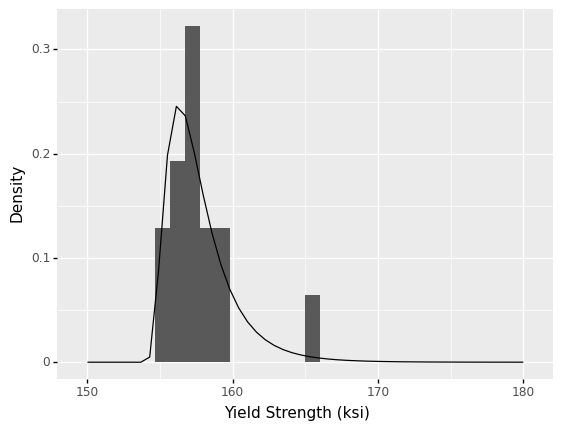

<ggplot: (8734590468051)>

In [8]:
## Evaluate marginal at many points
df_density = gr.df_make(TYS=np.linspace(150, 180))
df_density["l"] = list(map(marg_tys.l, df_density.TYS))

## Visualize
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_histogram(aes(y="stat(density)"), bins=30)
    + geom_line(
        data=df_density,
        mapping=aes(y="l")
    )
    
    + labs(
        y="Density",
        x="Yield Strength (ksi)"
    )
)

- Values of TYS where the Density is smaller will tend to occur less frequently
- Values of TYS where the Density is larger will tend to occur more frequently
- The *shape* of this distribution is asymmetric; the right tail (extreme right side) stretches much further than the left

### Q: How frequently would you expect `TYS == 150` to occur?

### Q: *Roughly*, what is the most-likely TYS value?


In [13]:
## Point of max PDF
res = minimize(
    lambda x: -1 * marg_tys.l(x),
    155
)
tys_max_pdf = res.x[0]
tys_max_pdf


156.28305687066222

### Q: How often should we expect to see `TYS == 156.28305687066222` in practice?


### Probability

Weirdly, for a continuous distribution (a PDF), we don't expect to see any *specific* value. Instead, we tend to think in terms of **areas** of a PDF.


TYS median ~ 157.167


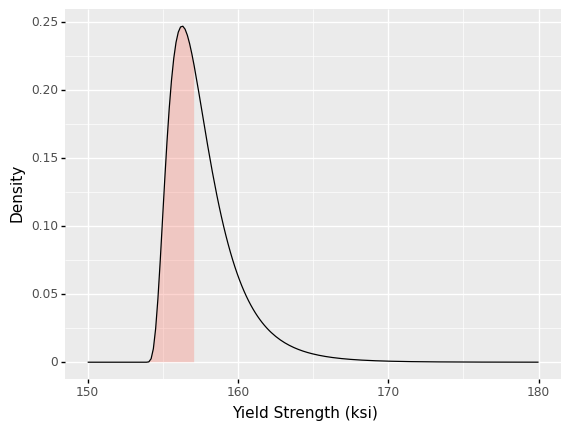

<ggplot: (8734590367757)>

In [19]:
## Compute median
tys_median = marg_tys.q(0.5)
print("TYS median ~ {0:4.3f}".format(tys_median))

## Evaluate marginal at many points
df_density = gr.df_make(TYS=np.linspace(150, 180, num=200))
df_density["l"] = list(map(marg_tys.l, df_density.TYS))

## Visualize
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_ribbon(
        data=df_density
        >> gr.tf_filter(DF.TYS <= tys_median),
        mapping=aes(ymax="l", ymin=0),
        fill="salmon",
        alpha=1/3,
    )
    + geom_line(
        data=df_density,
        mapping=aes(y="l")
    )
    
    + labs(
        y="Density",
        x="Yield Strength (ksi)"
    )
)


The median is the value that divides the PDF in "half"; we can use the median to give us a strength value at which parts will break at a rate of 1 in 2, aka 50%, aka $0.5$.


Since probability is defined in terms of an area, when we think about probability we have to think in terms of **sets** (not single values).

$$\mathbb{P}[X \in A] = \int_{x \in A} \text{PDF}(x) dx$$

We'll come back to this definition in our next class.


### Cumulative Distribution Function

The *indefinite integral* of the PDF is called the *cumulative distribution function* (CDF):

$$\text{CDF}(x) = \int_{-\infty}^x \text{PDF}(x') dx'$$

> The CDF tells us the area to the left of a given point $x$

We can access the CDF of a marginal with dot `.` notation via `marg.p(x)`. Here `p` stands for probability; unlike the PDF, the CDF does return a probability:


In [20]:
## Evaluate the CDF at the median
marg_tys.p(tys_median)


0.5000000000000017

Above, we saw that the median was the point that cuts the PDF "in half"---this CDF calculation verifies that assertion. Here we see that `tys_median` has `0.5` of the PDF below, and thus `0.5` of the PDF above.

### Connection to "NOT FOR DESIGN"

Remember this scary statement from the 
[MatWeb aluminum page](http://www.matweb.com/search/datasheet_print.aspx?matguid=1b8c06d0ca7c456694c7777d9e10be5b)?

> Data points with the AA note have been provided by the Aluminum Association, Inc. and are NOT FOR DESIGN.

The median (also the mean) are sometimes used for *typical values*; the AA values for strength reported are typical values. This means, if you design parts using those values (and load to designed failure), you will tend to get a failure rate of 50%. This probably isn't what you want in most cases!


### *Aside*: Upper-side of distribution

We can also get the area for values above a threshold $x$ by taking $1 - \text{CDF}(x)$. For instance, here's an area on the right-side of a distribution:


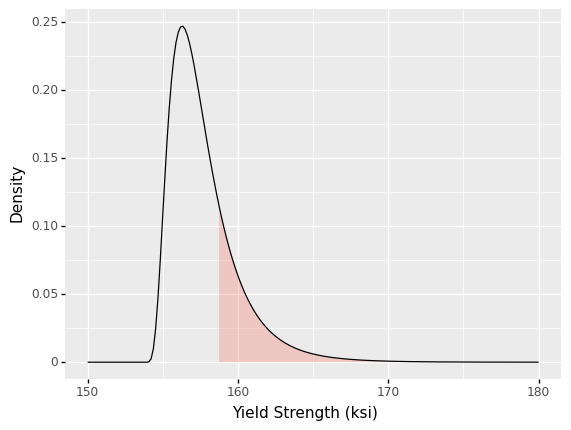

<ggplot: (8734590368085)>

In [26]:
## Compute median
tys_q75 = float(marg_tys.q(0.75))

## Evaluate marginal at many points
df_density = gr.df_make(TYS=np.linspace(150, 180, num=200))
df_density["l"] = list(map(marg_tys.l, df_density.TYS))

## Visualize
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_ribbon(
        data=df_density
        >> gr.tf_filter(tys_q75 <= DF.TYS),
        mapping=aes(ymax="l", ymin=0),
        fill="salmon",
        alpha=1/3,
    )
    + geom_line(
        data=df_density,
        mapping=aes(y="l")
    )
    
    + labs(
        y="Density",
        x="Yield Strength (ksi)"
    )
)


We can compute this area with the CDF using 1 - CDF:


In [27]:
## Evaluate the CDF at the median
1 - marg_tys.p(tys_q75)


0.2500000000000008

Apparently this upper shaded region is 25% of the PDF.


### Quantile Function

The *inverse* of the CDF is called the *quantile function*:

$$\text{Q}(p) = \text{CDF}^{-1}(p)$$

Note that the quantile function takes in a *probability*; it returns a specific value of the associated random variable. We can use this to find values that bracket a specified fraction of a PDF.


### Using the quantile function for design

What if we want to find a strength value where parts will break at a rate of 1 in 100? We can use the quantile function to compute such a value.

We can access the quantile function of a marginal in Grama using `marg.q(p)`; remember that the quantile function takes a probability and returns a random variable value.


TYS lower ~ 154.698


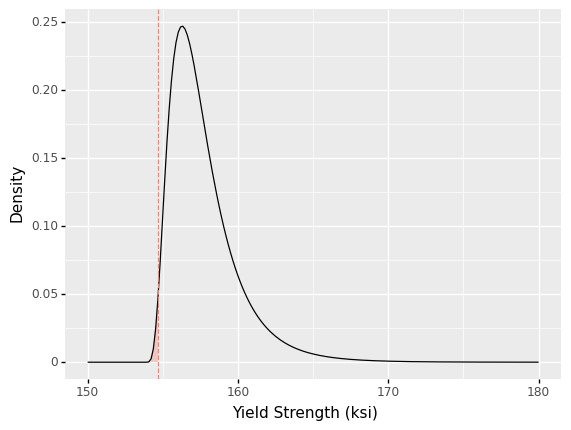

<ggplot: (8734590367997)>

In [22]:
## Compute lower quantile as design value
tys_lower = marg_tys.q(0.01)
print("TYS lower ~ {0:4.3f}".format(tys_lower))

## Evaluate marginal at many points
df_density = gr.df_make(TYS=np.linspace(150, 180, num=200))
df_density["l"] = list(map(marg_tys.l, df_density.TYS))

## Visualize
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_ribbon(
        data=df_density
        >> gr.tf_filter(DF.TYS <= tys_lower),
        mapping=aes(ymax="l", ymin=0),
        fill="salmon",
        alpha=1/3,
    )
    + geom_line(
        data=df_density,
        mapping=aes(y="l")
    )
    + geom_vline(
        xintercept=tys_lower,
        linetype="dashed",
        color="salmon",
    )
    
    + labs(
        y="Density",
        x="Yield Strength (ksi)"
    )
)

Now this is a value we might use for design! In reality we need to consider *statistics* as well as probability (we're only doing probability right now), but you can read up on [tolerance intervals](https://en.wikipedia.org/wiki/Tolerance_interval) if you want to learn more. But just for good measure, here's that warning again:

### Important Caveat: This class does **not** satisfy the prob/stat requirement...

Let me give you a warning:

> I'm going to teach you useful content in this class. However, I'm going to gloss over the whole subject of statistics. So long as you're dealing not dealing with safety-critical systems, you can get far with what I'm going to teach. If you're working on safety-critical systems someday, make sure to take a class on statistics, or better yet on reliability engineering.


### Mini-Summary: PDF, CDF, Quantile function

| Function | Input | Output | Example use |
|---|---|---|---|
| PDF | Variable $x$ | Likelihood $l$ | Plot to get a sense of "shape" |
| CDF | Variable $x$ | Probability $p$ | Check fraction below a value $x$ |
| Quantile | Probability $p$ | Variable $x$ | Pick conservative value for design |


## Where are we going with this?

What does this have to do with optimization? When designing safety-critical systems we often want to prevent failure at a particular rate:

$$\min\, \text{Mass}$$
$$\text{wrt.}\, \text{Design variables}$$
$$\text{s.t.}\, \mathbb{P}[\text{Catastrophic failure}] \leq \mathcal{F} = 10^{-6}$$

The specific failure rates $\mathcal{F}$ vary based on discipline. For instance, in [aerospace engineering](https://www.law.cornell.edu/cfr/text/14/25.613) we use values like $\mathcal{F}_{\text{B-basis}} = 0.1$ and $\mathcal{F}_{\text{A-basis}} = 0.01$. Part of the [research](https://purl.stanford.edu/xy114jv5352) I do is on whether or not this is a good idea....


### Mode, Median, Mean

![vis](./images/vis_mode_median_mean.png)

Via [Wikimedia Commons](https://en.wikipedia.org/wiki/Probability_density_function#/media/File:Visualisation_mode_median_mean.svg), Cmglee
